# Points Per Shot Analysis

This notebook analyzes **Points Per Shot (PPS)** - the average point value generated per shot attempt.

## What is PPS?
- **Formula:** Total Points / Total Shots
- **Range:** 0 (all misses) to 3.0 (100% on 3-pointers)
- **Why it matters:** Combines accuracy and shot value into one efficiency metric

## Analysis
- Calculate team-wide PPS for the season
- Break down PPS by shot zone
- Identify which zones generate the most value per attempt

In [1]:
# Setup - Import libraries and configure
import sys
from pathlib import Path

# Add parent directory to path so we can import bulls
sys.path.insert(0, str(Path().absolute().parent))

from bulls import data, analysis, viz
from bulls.config import CURRENT_SEASON
import pandas as pd
import matplotlib.pyplot as plt

# Configure matplotlib for better display in notebooks
plt.style.use('default')
%matplotlib inline

print("Bulls Analytics loaded")
print(f"Season: {CURRENT_SEASON}")

Bulls Analytics loaded
Season: 2025-26


## Step 1: Fetch Team Shot Data

In [2]:
# Fetch team shots for the current season
print("Fetching team shot data...")
shots = data.get_team_shots(season=CURRENT_SEASON)

if shots.empty:
    print("No shot data available")
else:
    print(f"Loaded {len(shots):,} shots from {shots['game_id'].nunique()} games")

Fetching team shot data...
Loaded 3,815 shots from 42 games


## Step 2: Season Total PPS

Calculate the team's overall points per shot for the entire season.

In [3]:
# Calculate overall PPS
pps = analysis.points_per_shot(shots)

print(f"=== Bulls Season PPS ===")
print(f"Points Per Shot: {pps['pps']:.3f}")
print(f"Total Points:    {pps['total_points']:,}")
print(f"Total Shots:     {pps['total_shots']:,}")
print(f"FG%:             {pps['fg_pct']:.1f}%")

=== Bulls Season PPS ===
Points Per Shot: 1.104
Total Points:    4,213
Total Shots:     3,815
FG%:             47.4%


## Step 3: PPS by Zone

Break down points per shot by each shot zone to see where the team generates the most value.

In [4]:
# Calculate PPS by zone
pps_zones = analysis.points_per_shot(shots, by_zone=True)

# Convert to DataFrame for better display
zone_data = []
for zone, stats in pps_zones['by_zone'].items():
    zone_data.append({
        'Zone': zone,
        'PPS': stats['pps'],
        'Points': stats['total_points'],
        'Shots': stats['total_shots'],
        'FG%': stats['fg_pct']
    })

zone_df = pd.DataFrame(zone_data).sort_values('PPS', ascending=False)
zone_df = zone_df.reset_index(drop=True)

print("=== PPS by Zone (sorted by efficiency) ===")
print(zone_df.to_string(index=False))

=== PPS by Zone (sorted by efficiency) ===
                 Zone   PPS  Points  Shots   FG%
            Backcourt 3.000       3      1 100.0
       Right Corner 3 1.312     282    215  43.7
      Restricted Area 1.268    1720   1356  63.4
        Left Corner 3 1.097     261    238  36.6
    Above the Break 3 1.033    1233   1194  34.4
In The Paint (Non-RA) 0.906     578    638  45.3
            Mid-Range 0.786     136    173  39.3


## Step 4: Visualize Zone Efficiency

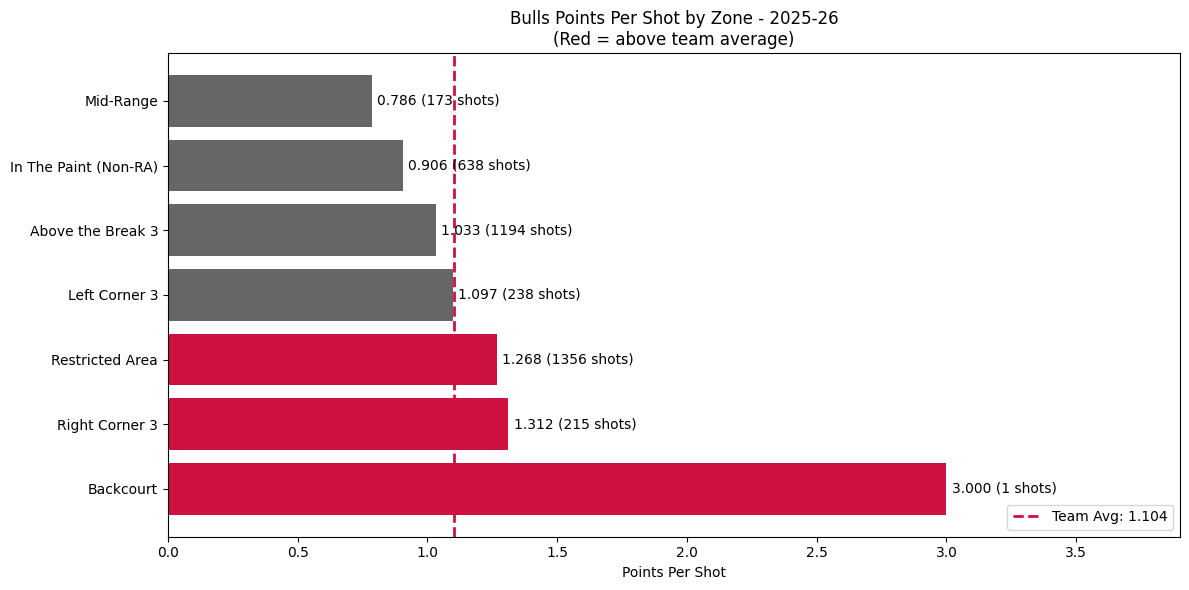

In [5]:
# Create bar chart of PPS by zone
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by PPS for visualization
colors = ['#CE1141' if pps > pps_zones['overall']['pps'] else '#666666' 
          for pps in zone_df['PPS']]

bars = ax.barh(zone_df['Zone'], zone_df['PPS'], color=colors)

# Add team average line
ax.axvline(x=pps_zones['overall']['pps'], color='#CE1141', linestyle='--', 
           linewidth=2, label=f"Team Avg: {pps_zones['overall']['pps']:.3f}")

# Add value labels
for bar, row in zip(bars, zone_df.itertuples()):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f"{row.PPS:.3f} ({row.Shots} shots)",
            va='center', fontsize=10)

ax.set_xlabel('Points Per Shot')
ax.set_title(f'Bulls Points Per Shot by Zone - {CURRENT_SEASON}\n(Red = above team average)')
ax.legend(loc='lower right')
ax.set_xlim(0, max(zone_df['PPS']) * 1.3)

plt.tight_layout()
plt.show()

## Step 5: Zone Volume vs Efficiency

Compare shot volume (how often we shoot from each zone) against efficiency (PPS).

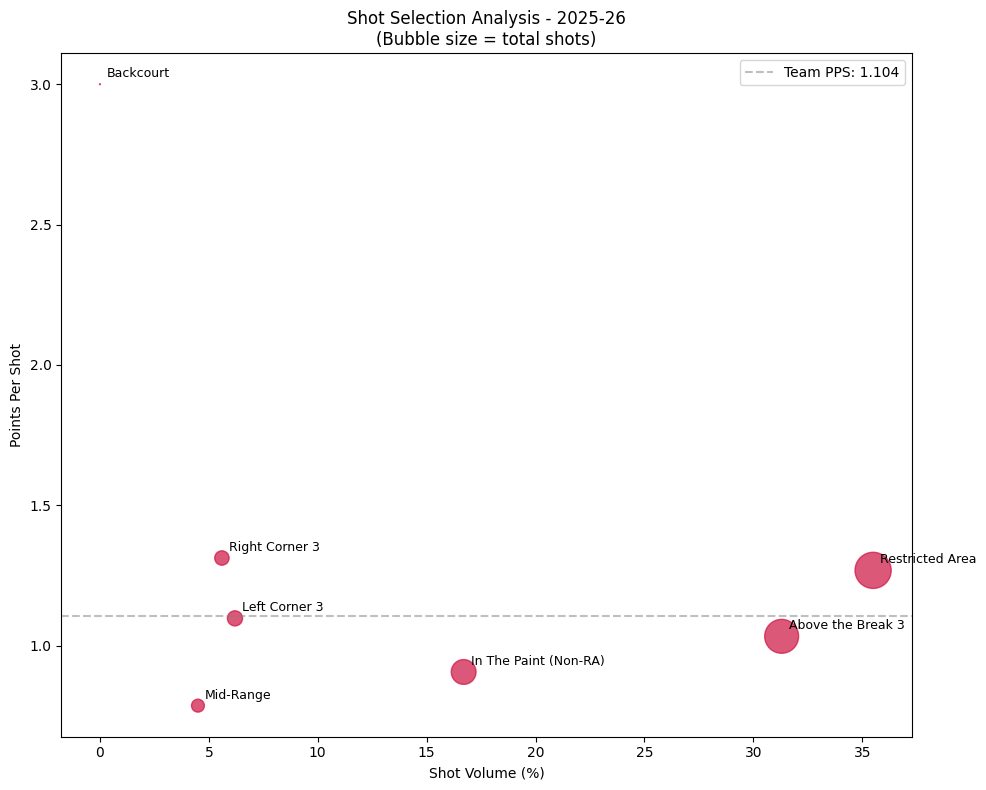

In [6]:
# Scatter plot: Volume vs Efficiency
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate shot percentage for each zone
zone_df['Shot%'] = (zone_df['Shots'] / zone_df['Shots'].sum() * 100).round(1)

scatter = ax.scatter(zone_df['Shot%'], zone_df['PPS'], 
                     s=zone_df['Shots']/2, c='#CE1141', alpha=0.7)

# Add zone labels
for _, row in zone_df.iterrows():
    ax.annotate(row['Zone'], (row['Shot%'], row['PPS']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add reference lines
ax.axhline(y=pps_zones['overall']['pps'], color='gray', linestyle='--', 
           alpha=0.5, label=f"Team PPS: {pps_zones['overall']['pps']:.3f}")

ax.set_xlabel('Shot Volume (%)')
ax.set_ylabel('Points Per Shot')
ax.set_title(f'Shot Selection Analysis - {CURRENT_SEASON}\n(Bubble size = total shots)')
ax.legend()

plt.tight_layout()
plt.show()

## Summary

**Key Insights:**
- **PPS** tells you how many points to expect per shot attempt from each zone
- Zones above the team average (in red) are where the Bulls generate the most efficient offense
- The scatter plot shows if shot selection aligns with efficiency (ideally, high-volume zones should have high PPS)